In [1]:
# %pip install kagglehub
# %pip install pandas
# %pip install pennylane
# %pip install torch
# %pip install scikit-learn
# %pip install matplotlib

In [2]:
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split, WeightedRandomSampler
import pennylane as qml
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (precision_recall_curve, average_precision_score, average_precision_score, f1_score, balanced_accuracy_score,
                             roc_curve, auc, brier_score_loss,
                             classification_report, confusion_matrix, accuracy_score)
from sklearn.calibration import calibration_curve
import kagglehub
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

DATA PREPROCESSING

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# KAGGLE_DATASET = "mirichoi0218/insurance"
KAGGLE_DATASET = "leandrenash/enhanced-health-insurance-claims-dataset"
data_dir = kagglehub.dataset_download(KAGGLE_DATASET)
# CSV_PATH = os.path.join(data_dir, "insurance.csv")
CSV_PATH = os.path.join(data_dir, "enhanced_health_insurance_claims.csv")

def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """Drop columns/rows that are fully empty and safely handle NaN/'' values."""
    df = df.copy()

    df = df.dropna(axis=1, how="all")

    df = df.replace(r'^\s*$', np.nan, regex=True)

    for col in df.select_dtypes(include=[np.number]).columns:
        if df[col].isna().any():
            df[col] = df[col].fillna(df[col].median())

    for col in df.select_dtypes(exclude=[np.number]).columns:
        if df[col].isna().any():
            if df[col].isna().all():
                df = df.drop(columns=[col])
            else:
                df[col] = df[col].fillna(df[col].mode()[0])

    return df

df_raw = pd.read_csv(CSV_PATH)
df_raw = clean_dataframe(df_raw)
print("Loaded + cleaned:", df_raw.shape)
display(df_raw.head())

possible_cost_cols = ["claim_amount", "claim_total", "billed_amount", "claim_value", "charges"]

lower_cols = {c.lower(): c for c in df_raw.columns}


def detect_cost_column(df: pd.DataFrame) -> str:
    cols = list(df.columns)
    lowmap = {c.lower(): c for c in cols}

    exact_priority = [
        "claimamount", "claim_amount",
        "claimtotal", "claim_total",
        "billedamount", "billed_amount",
        "claimvalue", "claim_value",
        "charges", "charge_amount", "chargeamount",
        "paidamount", "paid_amount"
    ]
    for k in exact_priority:
        if k in lowmap:
            return lowmap[k]
    name_blacklist = re.compile(r"(income|salary|wage|payroll|household|earnings)", re.I)
    claim_like      = re.compile(
        r"(claim.*(amount|total|value|charge|paid))|"
        r"((amount|total|value|charge|paid).*(claim))|"
        r"(^charges?$)|(^billed.*amount$)",
        re.I
    )

    candidates = []
    for c in cols:
        cl = c.lower()
        if name_blacklist.search(cl):
            continue
        if claim_like.search(c):
            if pd.api.types.is_numeric_dtype(df[c]):
                ser = pd.to_numeric(df[c], errors="coerce")
                pos_rate = (ser.fillna(0) > 0).mean()
                if pos_rate > 0.05:
                    candidates.append(c)

    if candidates:
        scored = []
        for c in candidates:
            v = pd.to_numeric(df[c], errors="coerce")
            p95 = np.nanpercentile(v, 95)
            scored.append((p95, c))
        scored.sort(reverse=True)
        return scored[0][1]
    raise ValueError(
        "Could not confidently identify a claim cost column. "
        "Looked for claim-related names like ClaimAmount/ClaimTotal/BilledAmount/Charges."
    )

cost_col = detect_cost_column(df_raw)
print(f"Using `{cost_col}` as the cost column for high/low risk labeling.")

q90 = df_raw[cost_col].quantile(0.90)
df = df_raw.copy()
df["risk"] = np.where(df[cost_col] >= q90, "high", "not_high")

# --- Drop ID-like columns ---
id_like = {"policy_id", "member_id", "claim_id", "customer_id", "policy_number", "patientid", "providerid"}
drop_cols = [c for c in df.columns if any(tok in str(c).lower() for tok in id_like)]
print("Dropping ID-like columns:", drop_cols)

X = df.drop(columns=["risk"] + drop_cols)
y = df["risk"]

num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_cols = [c for c in X.columns if c not in num_cols]

ohe_kwargs = dict(handle_unknown="ignore")
try:
    OneHotEncoder(sparse_output=False, **ohe_kwargs)
    ohe = OneHotEncoder(sparse_output=False, **ohe_kwargs)
except TypeError:
    ohe = OneHotEncoder(sparse=False, **ohe_kwargs)

prep = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", ohe,             cat_cols),
])

X_proc = prep.fit_transform(X)
if hasattr(X_proc, "toarray"): 
    X_proc = X_proc.toarray()
X_proc = np.asarray(X_proc, dtype=np.float32)

# labels -> {0:not_high, 1:high}
y_enc = LabelEncoder().fit_transform(y)
class_names = ["not_high", "high"]

X_tensor = torch.tensor(X_proc, dtype=torch.float32)
y_tensor = torch.tensor(y_enc, dtype=torch.long)

# Splits (70/15/15)
full_dataset = TensorDataset(X_tensor, y_tensor)
n = len(full_dataset)
n_tr = int(0.7*n); n_va = int(0.15*n); n_te = n - n_tr - n_va
gen = torch.Generator().manual_seed(42)
train_subset, val_subset, test_subset = random_split(full_dataset, [n_tr, n_va, n_te], generator=gen)
idx_tr, idx_va, idx_te = np.array(train_subset.indices), np.array(val_subset.indices), np.array(test_subset.indices)

y_tr = y_tensor[idx_tr]
num_classes = 2
counts = np.bincount(y_tr.numpy(), minlength=num_classes)
counts[counts == 0] = 1
class_weights = torch.tensor((counts.sum() / (num_classes * counts)).astype(np.float32))

sample_weights = class_weights[y_tr].double()
train_sampler = WeightedRandomSampler(weights=sample_weights,
                                      num_samples=len(sample_weights),
                                      replacement=True)

batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, sampler=train_sampler)
val_loader   = DataLoader(val_subset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_subset,  batch_size=batch_size, shuffle=False)

Loaded + cleaned: (4500, 17)


,ClaimID,PatientID,ProviderID,ClaimAmount,ClaimDate,DiagnosisCode,ProcedureCode,PatientAge,PatientGender,ProviderSpecialty,ClaimStatus,PatientIncome,PatientMaritalStatus,PatientEmploymentStatus,ProviderLocation,ClaimType,ClaimSubmissionMethod
0,10944daf-f7d5-4e1d-8216-72ffa609fe41,8552381d-7960-4f64-b190-b20b8ada00a1,4a4cb19c-4863-41cf-84b0-c2b21aace988,3807.95,2024-06-07,yy006,hd662,16,M,Cardiology,Pending,90279.43,Married,Retired,Jameshaven,Routine,Paper
1,fcbebb25-fc24-4c0f-a966-749edcf83fb1,327f43ad-e3bd-4473-a9ed-46483a0a156f,422e02dd-c1fd-43dd-8af4-0c3523f997b1,9512.07,2023-05-30,tD052,mH831,27,M,Pediatrics,Approved,130448.02,Single,Student,Beltrantown,Routine,Online
2,9e9983e7-9ea7-45f5-84d8-ce49ccd8a4a1,6f3acdf7-73aa-4afa-9c2e-b25b27bdb5b0,f7733b3f-0980-47b5-a7a0-ee390869355b,7346.74,2022-09-27,zx832,dg637,40,F,Cardiology,Pending,82417.54,Divorced,Employed,West Charlesport,Emergency,Online
3,a06273ed-44bb-452b-bbad-8618de080494,5d58e183-701e-406c-a8c6-5b73cac5e912,f7a04581-de96-44ee-b773-8adac02baa59,6026.72,2023-06-25,kr421,kG326,65,M,Neurology,Pending,68516.96,Widowed,Student,West Aprilhaven,Routine,Phone
4,f702a717-254b-4cff-a0c7-8395db2f6616,8a8ebdf6-3af0-4f14-82f3-37b937c3d270,b80b9e77-97f0-47d7-b561-19f9658a7bdf,1644.58,2023-07-24,LZ261,cx805,24,M,General Practice,Pending,84122.17,Married,Student,Lake Michele,Inpatient,Phone


Using `ClaimAmount` as the cost column for high/low risk labeling.
Dropping ID-like columns: ['PatientID', 'ProviderID']


Quantum-Hybrid QNN

Matplotlib is building the font cache; this may take a moment.


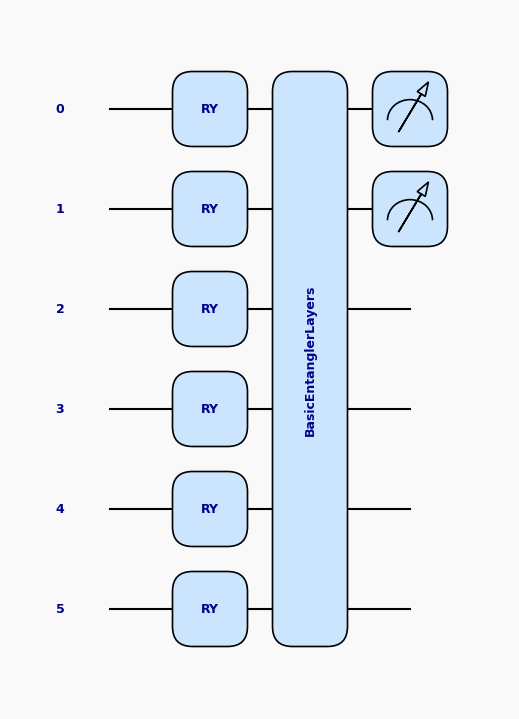

In [4]:
qdevice = qml.device("default.qubit", wires=6)

@qml.qnode(qdevice, interface="torch")
def quantum_circuit(inputs, weights):
    for i in range(6):
        qml.RY(inputs[i % len(inputs)], wires=i)
    qml.templates.BasicEntanglerLayers(weights, wires=range(6))
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

torch.manual_seed(0)
inputs_ex  = torch.linspace(0.1, 0.6, steps=6)
weights_ex = torch.randn(4, 6) * 0.5

fig, ax = qml.draw_mpl(quantum_circuit, style="pennylane")(inputs_ex, weights_ex)
fig.patch.set_facecolor("#f9f9f9")
ax.set_facecolor("#f0f4ff")
for patch in ax.patches:
    patch.set_edgecolor("black")
    patch.set_linewidth(1.2)
    patch.set_facecolor("#cce5ff")
for text in ax.texts:
    text.set_color("darkblue")
    text.set_fontsize(9)
plt.show()


q_shapes = {"weights": (4, 6)}

quantum_layer1 = qml.qnn.TorchLayer(quantum_circuit, q_shapes).to(device)
quantum_layer2 = qml.qnn.TorchLayer(quantum_circuit, q_shapes).to(device)

class HybridQuantumMLPClassifier(nn.Module):
    def __init__(self, in_dim, hidden_dim=64, p_drop=0.15):
        super().__init__()
        self.fc1   = nn.Linear(in_dim, hidden_dim)
        self.bn1   = nn.BatchNorm1d(hidden_dim)
        self.drop1 = nn.Dropout(p=p_drop)
        self.fc2 = nn.Linear(hidden_dim, 6)
        self.quantum1 = quantum_layer1
        self.fc_q_in = nn.Sequential(
            nn.Linear(2, 6),
            nn.ReLU(inplace=True)
        )
        self.quantum2 = quantum_layer2
        self.fc_out = nn.Linear(2, 2)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.drop1(x)
        x = torch.relu(self.fc2(x))
        x = torch.stack([self.quantum1(xi) for xi in x], dim=0)
        x = self.fc_q_in(x)
        x = torch.stack([self.quantum2(xi) for xi in x], dim=0)
        x = self.fc_out(x)
        return x

Train

In [5]:
def train_model(model, train_loader, val_loader,
                epochs=12, patience=4, lr=3e-4, wd=1e-5,
                class_weights=None):

    model.to(device)
    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    crit  = nn.CrossEntropyLoss(
        weight=class_weights.to(device) if class_weights is not None else None,
        label_smoothing=0.03
    )

    best_ap, best_state, best_thr = -np.inf, None, 0.5
    patience_ctr = 0

    for ep in range(1, epochs+1):
        model.train()
        loop = tqdm(train_loader, desc=f"Epoch [{ep}/{epochs}]", leave=False)
        for xb, yb in loop:
            xb, yb = xb.to(device), yb.to(device)
            optim.zero_grad()
            logits = model(xb)
            loss = crit(logits, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optim.step()
            loop.set_postfix(loss=float(loss))

        # ---- validation
        model.eval()
        probs, true = [], []
        with torch.no_grad():
            for xv, yv in val_loader:
                xv = xv.to(device)
                p = torch.softmax(model(xv), dim=1)[:, 1]  # P(high)
                probs.append(p.cpu().numpy()); true.append(yv.numpy())
        probs = np.concatenate(probs); true = np.concatenate(true).astype(int)

        # monitor AP(high)
        ap = average_precision_score(true, probs)

        # threshold tuning for macro-F1 (finer grid)
        thr_grid = np.linspace(0.01, 0.99, 1000)
        f1s = [f1_score(true, (probs >= t).astype(int), average="macro") for t in thr_grid]
        bacc = [balanced_accuracy_score(true, (probs >= t).astype(int)) for t in thr_grid]

        i_f1 = int(np.nanargmax(f1s))
        t_best, f1_best, bacc_best = float(thr_grid[i_f1]), float(f1s[i_f1]), float(bacc[i_f1])

        print(f"Epoch {ep} | Val AP(high)={ap:.3f} | "
            f"Best macro-F1={f1_best:.3f} @ Thr={t_best:.3f} | "
            f"Balanced Acc={bacc_best:.3f}")

        # early stopping on AP(high)
        if ap > best_ap + 1e-4:
            best_ap   = ap
            best_state= {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            best_thr  = t_best
            patience_ctr = 0
        else:
            patience_ctr += 1
            if patience_ctr >= patience:
                print("Early stopping.")
                break

    if best_state:
        model.load_state_dict(best_state)
    print(f"Best Val AP(high)={best_ap:.3f} with threshold={best_thr:.3f}")
    return best_thr


hybrid = HybridQuantumMLPClassifier(in_dim=X_proc.shape[1], hidden_dim=64)

best_thresh = train_model(
    hybrid, train_loader, val_loader,
    epochs=10, patience=4, class_weights=class_weights
)

Epoch 1 | Val AP(high)=0.991 | Best macro-F1=0.470 @ Thr=0.010 | Balanced Acc=0.500


Epoch 2 | Val AP(high)=0.997 | Best macro-F1=0.844 @ Thr=0.363 | Balanced Acc=0.939


Epoch 3 | Val AP(high)=0.997 | Best macro-F1=0.855 @ Thr=0.343 | Balanced Acc=0.932


Epoch 4 | Val AP(high)=0.995 | Best macro-F1=0.823 @ Thr=0.324 | Balanced Acc=0.853


Epoch 5 | Val AP(high)=0.995 | Best macro-F1=0.826 @ Thr=0.305 | Balanced Acc=0.870


Epoch 6 | Val AP(high)=0.995 | Best macro-F1=0.831 @ Thr=0.293 | Balanced Acc=0.902


Epoch 7 | Val AP(high)=0.995 | Best macro-F1=0.837 @ Thr=0.270 | Balanced Acc=0.852
Early stopping.
Best Val AP(high)=0.997 with threshold=0.343


Evaluate on test

In [6]:
def eval_with_threshold(model, loader, thr=0.5, title="Model (Test)"):
    thr = float(np.atleast_1d(thr)[0])

    model.eval()
    probs, true = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = model(xb)
            p = torch.softmax(logits, dim=1)[:, 1]
            probs.append(p.cpu().numpy()); true.append(yb.numpy())
    probs = np.concatenate(probs).ravel()
    true  = np.concatenate(true).astype(int).ravel()

    fpr, tpr, _ = roc_curve(true, probs, pos_label=1)
    rocA = auc(fpr, tpr)
    pr, rc, _ = precision_recall_curve(true, probs, pos_label=1)
    ap = average_precision_score(true, probs)
    pt, pp = calibration_curve(true, probs, n_bins=10, strategy="uniform")
    brier = brier_score_loss(true, probs)

    print(f"ROC-AUC={rocA:.3f} | PR-AP={ap:.3f} | Brier={brier:.3f}")

    pred = (probs >= thr).astype(int)
    print("Threshold:", thr)
    print("Accuracy:", f"{accuracy_score(true, pred)*100:.2f}%")
    print("\nClassification report:\n",
          classification_report(true, pred, target_names=["nonfraud","fraud"]))
    print("Confusion matrix:\n", confusion_matrix(true, pred))

    return {"roc_auc": float(rocA), "pr_ap": float(ap), "brier": float(brier)}, probs, true, pred

eval_with_threshold(hybrid, test_loader, thr=best_thresh, title="Hybrid Quantum MLP Classifier (Test)")

ROC-AUC=0.986 | PR-AP=0.999 | Brier=0.398
Threshold: 0.3425525525525525
Accuracy: 94.07%

Classification report:
               precision    recall  f1-score   support

    nonfraud       0.61      0.98      0.75        61
       fraud       1.00      0.94      0.97       614

    accuracy                           0.94       675
   macro avg       0.80      0.96      0.86       675
weighted avg       0.96      0.94      0.95       675

Confusion matrix:
 [[ 60   1]
 [ 39 575]]


({'roc_auc': 0.985849308485075,
  'pr_ap': 0.998613136866764,
  'brier': 0.3981613893157773},
 array([0.3473446 , 0.3440415 , 0.34851006, 0.3499911 , 0.3418447 ,
        0.34810334, 0.34287316, 0.34919754, 0.34234998, 0.34993654,
        0.34753615, 0.34999138, 0.35002974, 0.3488641 , 0.34455803,
        0.34417853, 0.35001916, 0.34420732, 0.34994528, 0.34734276,
        0.34602308, 0.34769323, 0.3482296 , 0.34176502, 0.3488966 ,
        0.34443426, 0.34276697, 0.34263772, 0.34982768, 0.34461406,
        0.34773743, 0.34837112, 0.34965906, 0.34329668, 0.34591532,
        0.3417612 , 0.3417532 , 0.34203637, 0.3472911 , 0.34975812,
        0.3489994 , 0.34215823, 0.34994465, 0.34784722, 0.34979975,
        0.34329626, 0.34919378, 0.34808302, 0.34726232, 0.34540868,
        0.34599444, 0.34176055, 0.3421546 , 0.34674183, 0.3446983 ,
        0.3498868 , 0.34916788, 0.3497474 , 0.34176582, 0.3489312 ,
        0.350015  , 0.3498    , 0.34489855, 0.3418419 , 0.34175497,
        0.34927583, 0.

Saving

In [7]:
os.makedirs("./insurance_artifacts/models", exist_ok=True)
torch.save(hybrid.state_dict(), "./insurance_artifacts/models/insurance_hybrid_quantum.pt")
print("Saved hybrid QNN to ./insurance_artifacts/models/insurance_hybrid_quantum.pt")

Saved hybrid QNN to ./insurance_artifacts/models/insurance_hybrid_quantum.pt


Upload model

In [8]:
# uploaded_model = torch.load("./insurance_artifacts/models/insurance_hybrid_quantum.pt", map_location="cpu")